In [1]:
import zipfile
zip_ref = zipfile.ZipFile("/content/station_hour_clean.csv.zip")
zip_ref.extractall()
zip_ref.close()

In [2]:
file_path = "/content/station_hour_clean.csv"

LOADING AND EXTRACTING

In [3]:
# loading the dataset

import pandas as pd

# Load the dataset (adjust path as needed)
df = pd.read_csv(file_path)

# Show all column names
print(df.columns)


<ipython-input-3-2147c6769b1a>:6: DtypeWarning: Columns (1,17,33,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket',
       'DL005', '17-03-2020 16:00', '37.5', '109.25', '0.45', '15.8', '8.77',
       '37.2', '0.2', '16.38', '111.23', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', '215', 'Poor', 'DL013', '20-05-2019 12:00', 'Unnamed: 2',
       'Unnamed: 3', '3.55', '16.89', '11.68', '19.08', '0.6', '14.62',
       'Unnamed: 10', '302', 'Very Poor', 'DL022', '14-08-2018 17:00', '33',
       '99.25', '1.72', '13.47', '8.6', '30.22', '1.68', '3.35', '38.2',
       '4.75', '158.03', '115', 'Moderate', 'hour', 'day', 'month', 'weekday',
       'year'],
      dtype='object')


In [4]:
# Preliminary Cleaning of the dataset


# Drop unnamed or irrelevant columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop duplicate rows if any
df = df.drop_duplicates()

# Convert 'Datetime' to datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Drop rows where datetime conversion failed
df = df.dropna(subset=['Datetime'])

# Sort by StationId and Datetime
df = df.sort_values(by=['StationId', 'Datetime']).reset_index(drop=True)

# Optional: drop rows with any missing air quality features
df = df.dropna(subset=['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI'])


In [5]:
# Feature Selection


# Features and label
feature_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
label_column = 'AQI'

features = df[feature_columns]
labels = df[label_column]


In [6]:
# Normalize


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame for easier handling
scaled_features = pd.DataFrame(scaled_features, columns=feature_columns)


In [7]:
# Creating Sequences


import numpy as np

n_steps = 24

X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features.iloc[i-n_steps:i].values)
    y.append(labels.iloc[i])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 24, features)
print("y shape:", y.shape)


X shape: (262119, 24, 12)
y shape: (262119,)


In [8]:
# Dataset spliting


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


MODEL ARCHITECTURE


In [12]:
# Model Definition



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(24, 12)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)  # Single output: predicted AQI
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,417 (95.38 KB)

 Trainable params: 24,417 (95.38 KB)

 Non-trainable params: 0 (0.00 B)

TRAINING LOOP


In [13]:
# Training


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=64,
    verbose=1
)


Epoch 1/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 50992.9414 - mae: 178.0771 - val_loss: 29985.4863 - val_mae: 126.1367
Epoch 2/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 26773.7793 - mae: 115.1671 - val_loss: 18006.9883 - val_mae: 103.2681
Epoch 3/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 18543.9062 - mae: 94.2052 - val_loss: 7292.5742 - val_mae: 50.0738
Epoch 4/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 8265.0039 - mae: 48.5052 - val_loss: 3210.1941 - val_mae: 29.3332
Epoch 5/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 4593.8574 - mae: 35.0018 - val_loss: 1662.1805 - val_mae: 20.9212
Epoch 6/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 2839.9429 - mae: 28.8763 - val_loss: 1035.3385 - val_mae: 17.9638
Epoch 7/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 1915.0620 - mae: 25.2573 - val_loss: 802.3553 - val_mae: 17.2479
Epoch 8/25
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 1501.3864 - mae: 23.4433 -

TRAINING DATA VISUALS


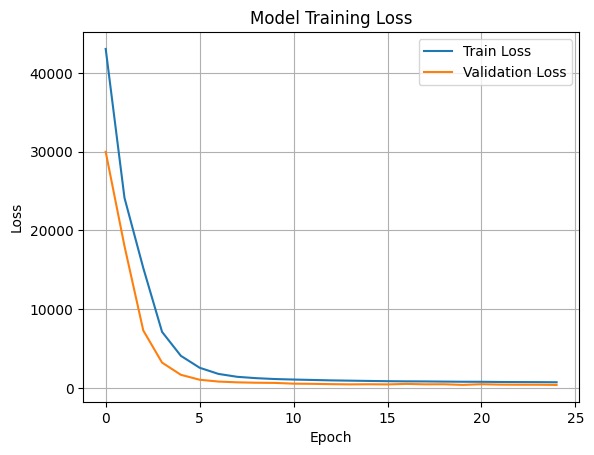

In [14]:
# Loss curves


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss')
plt.legend()
plt.grid(True)
plt.show()


SOME EVALUATION


In [9]:
from tensorflow.keras.models import load_model

model = load_model('/content/aqi_model_v1.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# Testing

y_pred = model.predict(X_test).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")


1639/1639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Test MAE: 11.05
Test RMSE: 19.39


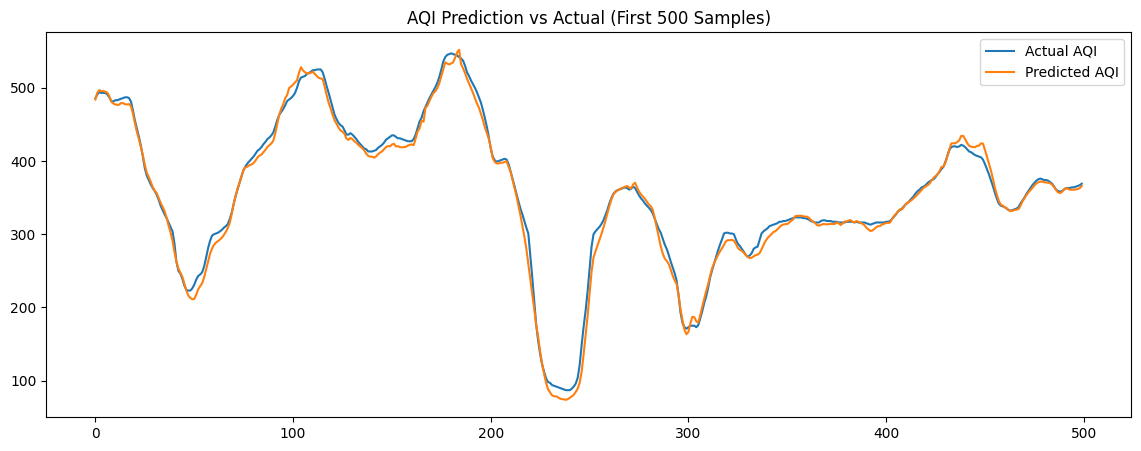

In [12]:
# VISUALIZING THE TEST

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test[:500], label='Actual AQI')
plt.plot(y_pred[:500], label='Predicted AQI')
plt.legend()
plt.title("AQI Prediction vs Actual (First 500 Samples)")
plt.show()


MODEL SAVING


In [22]:
model.save('aqi_model_v1.h5')

In [23]:
from google.colab import files

files.download('aqi_model_v1.keras') # For a single file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>